# Genshin Stats Study
I am going to explore this Genshin stats CSV. I'd like to try to predict a stat (HP) based on other stats if possible.

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read CSV data and store in a DataFrame
df = pd.read_csv('CharAtbMax.csv')

## Exploring the Data


In [4]:
[print("- " + x) for x in sorted(list(df.columns))]

- ATK
- Arma
- Atributo
- DEF
- Dano+DanoCritico
- HP
- Level
- Personagem
- SPAtrib
- TaxaCrit


[None, None, None, None, None, None, None, None, None, None]

In [5]:
df.isnull().sum()

Personagem          0
Level               0
Arma                0
HP                  0
ATK                 0
DEF                 0
SPAtrib             0
Atributo            0
TaxaCrit            0
Dano+DanoCritico    0
dtype: int64

In [6]:
df.describe()

,Level,HP,ATK,DEF,SPAtrib,TaxaCrit,Dano+DanoCritico
count,41.0,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,90.0,11528.829268,249.975610,716.073171,10.073805,0.064049,1.546829
std,0.0,1674.877666,57.049315,90.654672,30.296488,0.050621,0.127217
min,90.0,9189.000000,106.000000,573.000000,0.192000,0.050000,1.500000
25%,90.0,10164.000000,212.000000,648.000000,0.240000,0.050000,1.500000
50%,90.0,11201.000000,240.000000,710.000000,0.240000,0.050000,1.500000
75%,90.0,12907.000000,297.000000,789.000000,0.320000,0.050000,1.500000
max,90.0,15552.000000,349.000000,922.000000,115.000000,0.242000,1.884000


In [7]:
df.size

410

<AxesSubplot:xlabel='ATK', ylabel='HP'>

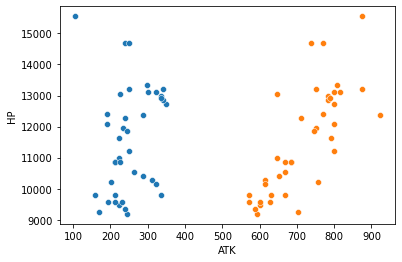

In [8]:
sns.scatterplot(data=df, x="ATK", y="HP")
sns.scatterplot(data=df, x="DEF", y="HP")

### Results
This is a small dataset (410 items) with no null values. I won't need to clean any rows. The column names are in a different language (Portuguese), but I can understand what the columns represent based on their data.

#### Columns
- ATK
- Arma: Weapon
- Atributo: Attribute
- DEF
- Dano+DanoCritico: Damage+Crit
- HP
- Level
- Personagem: Googled, "Character"
- SPAtrib: "Special Attribute"
- TaxaCrit: Googled, "Crit Rate"

#### Stat Trends
It looks like `ATK` and `DEF` positively correlate with `HP`. `ATK` has an outlier that will skew the results, probably resulting with the correlation looking flatter. I think this point should be removed when training the models.

## Cleaning
I'm going to rename the columns based on the translations I looked up and also cleanup some of the symbols to reduce the noise when looking at the fields.

In [9]:
df.columns = ['Character', 'Level', 'Weapon', 'HP', 'ATK', 'DEF', 'Special Attribute',
       'Attribute', 'Crit Rate', 'DMG+CritDMG']

In [10]:
df.head()

,Character,Level,Weapon,HP,ATK,DEF,Special Attribute,Attribute,Crit Rate,DMG+CritDMG
0,Amber,90,Arco,9461,223,601,0.240,%ATK,0.05,1.5
1,Barbara,90,Catalisador,9787,159,669,0.240,%Vida,0.05,1.5
2,Beidou,90,Espadão,13050,225,648,0.240,%DanoElectro,0.05,1.5
3,Bennett,90,Espada,12397,191,771,0.267,%RecargaEnergia,0.05,1.5
4,Chongyun,90,Espadão,10984,223,648,0.240,%ATK,0.05,1.5


### Attribute Cleaning
I'm going to translate the names of the Attribute column and remove the `%` symbol.

In [11]:
df.Attribute.unique()

array(['%ATK', '%Vida', '%DanoElectro', '%RecargaEnergia', '%TaxaCritica',
       '%BonusdeCura', '%DanoCritico', '%BonusDanoPyro',
       'ProficienciaElemental', '%BonusDanoGeo', '%DEF',
       '%BonusDanoFisico', '%BonusDanoAnemo', '%BonusDanoHydro',
       '%BonusDanoCryo'], dtype=object)

In [12]:
attribute_dict = {
    '%ATK': 'ATK', '%Vida': 'Life', '%DanoElectro': 'Lightning Damage', '%RecargaEnergia': 'Energy Recharge', '%TaxaCritica': 'Crit Rate',
       '%BonusdeCura': 'Healing Bonus', '%DanoCritico': 'Crit Damage', '%BonusDanoPyro': 'Fire Damage',
       'ProficienciaElemental': 'Elemental Proficiency', '%BonusDanoGeo': 'Earth Damage', '%DEF': 'DEF',
       '%BonusDanoFisico': 'Physical Damage', '%BonusDanoAnemo': 'Wind Damage', '%BonusDanoHydro': 'Water Damage',
       '%BonusDanoCryo': 'Ice Damage'
}

df.Attribute = df.Attribute.map(lambda x: attribute_dict[x])

In [13]:
df.Attribute.unique()

array(['ATK', 'Life', 'Lightning Damage', 'Energy Recharge', 'Crit Rate',
       'Healing Bonus', 'Crit Damage', 'Fire Damage',
       'Elemental Proficiency', 'Earth Damage', 'DEF', 'Physical Damage',
       'Wind Damage', 'Water Damage', 'Ice Damage'], dtype=object)

## Attribute Analysis

In [14]:
print(df.Attribute.value_counts())

ATK                      10
Energy Recharge           5
Crit Damage               5
Elemental Proficiency     4
Crit Rate                 3
Earth Damage              3
Healing Bonus             2
Fire Damage               2
DEF                       1
Physical Damage           1
Life                      1
Wind Damage               1
Ice Damage                1
Water Damage              1
Lightning Damage          1
Name: Attribute, dtype: int64


<AxesSubplot:xlabel='HP', ylabel='Count'>

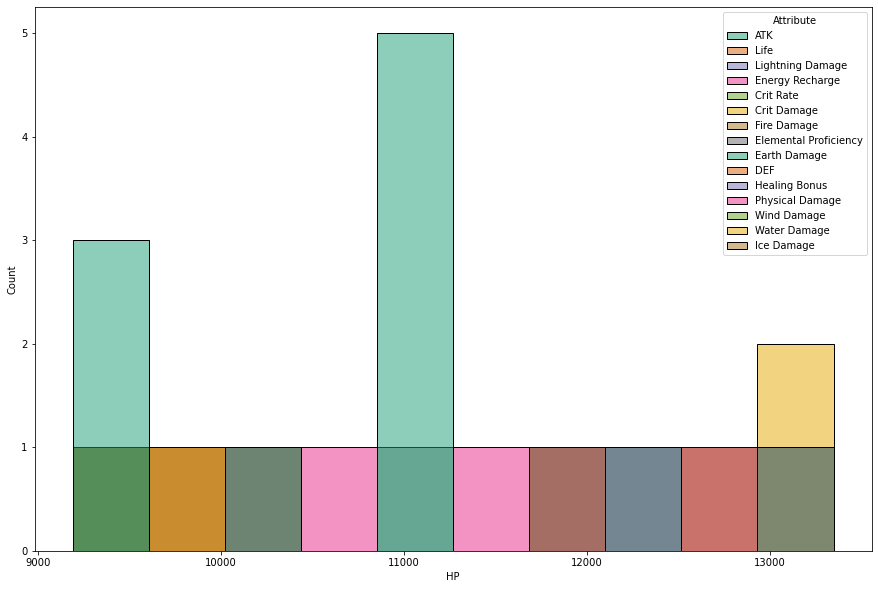

In [108]:
plt.figure(figsize=(15,10))

sns.histplot(data=df, x="HP", bins=10, hue="Attribute", palette="Dark2")


Characters with `Healing Bonus` attribute have high HP.

### Removing ATK Outlier


In [20]:
df.loc[:, ["Character", "ATK", "HP"]].sort_values(by=["HP", "ATK"], ascending=False).iloc[:3]

,Character,ATK,HP
33,Hu Tao,106,15552
26,Zhongli,251,14695
7,Jean,239,14695


In [21]:
df = df[df.Character != "Hu Tao"]

In [22]:
df.loc[:, ["Character", "ATK", "HP"]].sort_values(by=["HP", "ATK"], ascending=False).iloc[:3]


,Character,ATK,HP
26,Zhongli,251,14695
7,Jean,239,14695
36,Kaedehara Kazuha,297,13348


<AxesSubplot:xlabel='ATK', ylabel='HP'>

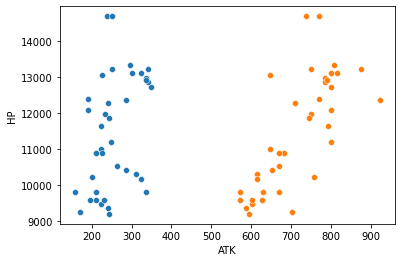

In [23]:
sns.scatterplot(data=df, x="ATK", y="HP")
sns.scatterplot(data=df, x="DEF", y="HP")

In [25]:
df.HP.describe()

count       40.000000
mean     11428.250000
std       1565.804925
min       9189.000000
25%      10072.250000
50%      11092.500000
75%      12870.250000
max      14695.000000
Name: HP, dtype: float64

In [30]:
df.HP.sort_values(ascending=False).iloc[:3]

7     14695
26    14695
36    13348
Name: HP, dtype: int64

In [31]:
df.sort_values(by="HP", ascending=False).iloc[:3]

,Character,Level,Weapon,HP,ATK,DEF,Special Attribute,Attribute,Crit Rate,DMG+CritDMG
7,Jean,90,Espada,14695,239,769,0.222,Healing Bonus,0.05,1.5
26,Zhongli,90,Lança,14695,251,738,0.288,Earth Damage,0.05,1.5
36,Kaedehara Kazuha,90,Espada,13348,297,807,115.000,Elemental Proficiency,0.05,1.5


In [32]:
14695 - 13348

1347

In [33]:
1347 / 1565.804925

0.8602604184553833

### More Outliers
The top two HP Characters after removing the ATK outlier are 0.86 std away *from the next highest HP*. I will remove them as well.

In [36]:
remove_names = df.sort_values(by="HP", ascending=False).Character.iloc[:2]
remove_names

7        Jean
26    Zhongli
Name: Character, dtype: object

In [46]:
df = df[~df.Character.isin(remove_names)]

<AxesSubplot:xlabel='ATK', ylabel='HP'>

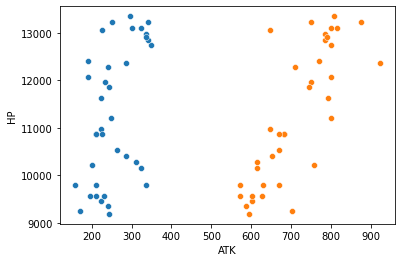

In [47]:
sns.scatterplot(data=df, x="ATK", y="HP")
sns.scatterplot(data=df, x="DEF", y="HP")

## Linear Regression Models
I'm going to test linear regressions for both `ATK -> HP` and `DEF -> HP` and compare their results using Mean Absolute Error

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

lin_atk_model = LinearRegression()
lin_def_model = LinearRegression()

# Features + Target for splitting
X_atk = df['ATK']
y_atk = df.HP

# Features + Target for splitting
X_def = df['DEF']
y_def = df.HP


X_train_atk, X_test_atk, y_train_atk, y_test_atk = train_test_split(X_atk, y_atk, random_state=1, test_size=0.2)
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(X_def, y_def, random_state=1, test_size=0.2)

In [83]:
lin_def_model.fit(X_train_def.values.reshape(-1,1), y_train_def.values.reshape(-1,1))
lin_atk_model.fit(X_train_atk.values.reshape(-1,1), y_train_atk.values.reshape(-1,1))

LinearRegression()

In [88]:
pred_atk = lin_atk_model.predict(X_test_atk.values.reshape(-1,1))
pred_def = lin_def_model.predict(X_test_def.values.reshape(-1,1))

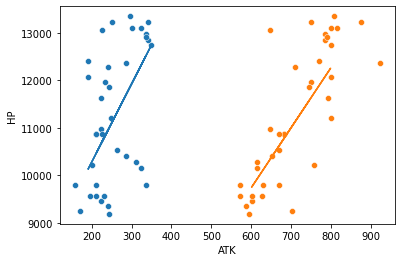

In [89]:
sns.scatterplot(data=df, x="ATK", y="HP")
sns.scatterplot(data=df, x="DEF", y="HP")
plt.plot(X_test_atk, pred_atk)
plt.plot(X_test_def, pred_def)

In [94]:
mae_atk = mean_absolute_error(pred_atk, y_test_atk)
mae_def = mean_absolute_error(pred_def, y_test_def)

print(f"ATK MAE: {mae_atk}")
print(f"DEF MAE: {mae_def}")
print(f"HP  STD: {df.HP.std()}")

print(f"ATK is {mae_atk/df.HP.std()} STDs")
print(f"DEF is {mae_def/df.HP.std()} STDs")

ATK MAE: 1329.3620104742813
DEF MAE: 736.5577954646224
HP  STD: 1406.0815228617237
ATK is 0.945437365373169 STDs
DEF is 0.523837191150585 STDs


#### Results
`DEF` is a better predictor of `HP` than `ATK`.

Can they be combined to create a better predictor, though?